Import Libraries:

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error

from surprise import Dataset
from surprise import Reader  
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
from surprise.accuracy import rmse
from collections import defaultdict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from IPython.display import display, Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # change the cell width

Read and explore the dataset:

In [2]:
df = pd.read_csv('ratings_Electronics.csv', header=None)
df.columns = ['userId', 'productId', 'Rating', 'timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
print('This dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')
df.head()

This dataset has 7824482 rows, and 3 columns


,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


Checking for data types and NaN values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
Rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB



Total NaN values =  0


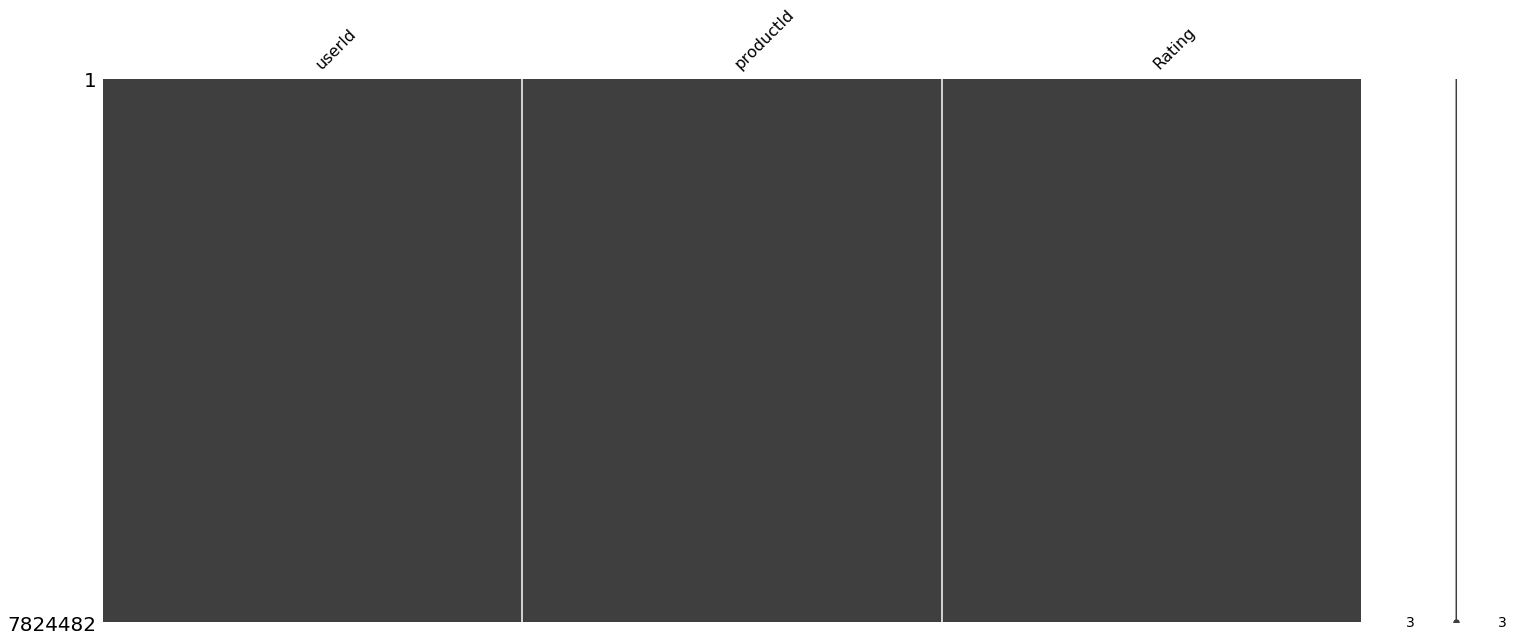

In [3]:
df.info()
msno.matrix(df)
print('\n\n\nTotal NaN values = ', df.isna().sum().sum())

Check the distribution of the ratings:

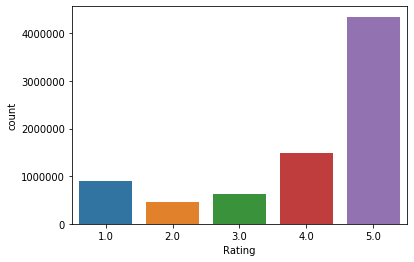

In [4]:
distribution = sns.countplot(df['Rating'])

In [5]:
print('There are {} unique users in the dataset'.format(df.userId.nunique()))
print('There are {} unique products in the dataset'.format(df.productId.nunique()))

There are 4201696 unique users in the dataset
There are 476002 unique products in the dataset


Take a subset of the dataset (users with at least 50 ratings) to make it denser:

In [6]:
df_userId = df.groupby(['userId']).agg('count')
selected_users = list(df_userId[df_userId['Rating']>=50].index)
df = df[df['userId'].isin(selected_users)]
df.reset_index(inplace=True, drop=True)

print('Now there are {} unique users in the dataset'.format(df.userId.nunique()))
print('Now there are {} unique products in the dataset'.format(df.productId.nunique()))

Now there are 1540 unique users in the dataset
Now there are 48190 unique products in the dataset


Shuffle the dataset because some learning algorithms are sensitive to the order of the training instances:

In [7]:
df = df.sample(frac=1, random_state=1)

Spliting the data in train and test set

I am going to use 70% of data for building the algorithm and 30% for the final test to have a realistic evaluation of the model in production:

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=1)
for train_index, test_index in split.split(df, df['Rating']):
    train = df.loc[train_index]
    train.reset_index(inplace=True,drop=True)
    test = df.loc[test_index]
    test.reset_index(inplace=True,drop=True)

print('%.0f records (%.0f%%) are used for traning \n%.0f records (%.0f%%) are used for testing' % (len(train), (100*len(train)/(len(df))), len(test), (100*len(test)/(len(df)))))

88109 records (70%) are used for traning 
37762 records (30%) are used for testing


Build Popularity Recommender model (Non-personalised) to consider both the mean and the number of ratings in equal measure:

In [9]:
mean_ratings = train.groupby('productId')['Rating'].mean()
count_ratings = train.groupby('productId')['Rating'].count()
popular_rec_system = pd.concat([pd.DataFrame(mean_ratings), pd.DataFrame(count_ratings)], axis=1)
popular_rec_system.columns = ['mean_ratings', 'count_ratings']
popular_rec_system['score'] = (popular_rec_system['mean_ratings']-1)/4 + (popular_rec_system['count_ratings']-popular_rec_system['count_ratings'].min()) / (popular_rec_system['count_ratings'].max()-popular_rec_system['count_ratings'].min())
popular_rec_system['score'] = (popular_rec_system['score']-popular_rec_system['score'].min()) / (popular_rec_system['score'].max()-popular_rec_system['score'].min())
popular_rec_system = popular_rec_system.sort_values('score', ascending=False)
popular_rec_system['Rank'] = popular_rec_system['score'].rank(ascending=0, method='first') 
popular_rec_system = popular_rec_system.head(5)
popular_rec_system

,mean_ratings,count_ratings,score,Rank
productId,,,,
B003ES5ZUU,4.876923,130,1.000000,1.0
B0088CJT4U,4.222973,148,0.977778,2.0
B007WTAJTO,4.780702,114,0.928038,3.0
B000N99BBC,4.775701,107,0.901576,4.0
B00829TIEK,4.476190,105,0.853664,5.0


Evaluation of the Popularity Recommender model on the test set only for the top 5 products:

In [23]:
df_popular_rec_system = pd.merge(test[test['productId'].isin(list(popular_rec_system.index))], popular_rec_system, left_on='productId', right_on='productId', how='left', suffixes=('', 'predicted')).drop(['count_ratings','score','Rank'], axis=1)
print('RMSE score:', round(mean_squared_error(df_popular_rec_system['Rating'].values, df_popular_rec_system['mean_ratings'].values, squared=False),2))

RMSE score: 0.83


Build Collaborative Filtering model. I will start using KNNWithMeans with a grid search:

In [38]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df.copy()[['userId', 'productId', 'Rating']], reader=reader)

param_grid = {'name': ['msd', 'cosine'],
               'min_support': [3, 4, 5],
               'user_based': [False, True]}

gs_knn = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
gs_knn.fit(data)

print('Best Parameters:', gs_knn.best_params['rmse'])
print('RMSE score:', round(gs_knn.best_score['rmse'],2))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

I can also try SVD:

In [26]:
param_grid = {'n_epochs': [1, 2],
              'n_factors': [100, 200],
              'lr_all': [0.004, 0.005],
              'reg_all': [0.4, 0.6]}

gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs_svd.fit(data)

print('Best Parameters:', gs_svd.best_params['rmse'])
print('RMSE score:', round(gs_svd.best_score['rmse'],2))

Best Parameters: {'n_epochs': 2, 'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.4}
RMSE score: 1.02


I use the best algo from the 2 grid searches and I train on the treaining set and validate on the test set:

In [41]:
trainset, testset = surprise_train_test_split(data, test_size=.3)

algo = gs_svd.best_estimator['rmse']
algo.fit(trainset)

predictions = algo.test(testset)
print('RMSE score:', round(accuracy.rmse(predictions, verbose=False),2))

RMSE score: 1.01


Get top 5 recommendations for each user:

In [42]:
def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions)

users = []
recommendations = []
for uid, user_ratings in top_n.items():
    users.append(uid)
    recommendations.append([iid for (iid, _) in user_ratings])

recommendations = pd.concat([pd.DataFrame(users), pd.DataFrame(recommendations)], axis=1)
recommendations.columns = ['userId', 'Rec 1', 'Rec 2', 'Rec 3', 'Rec 4', 'Rec 5']
recommendations.set_index('userId', drop=True, inplace=True)
recommendations.head()

,Rec 1,Rec 2,Rec 3,Rec 4,Rec 5
userId,,,,,
A1901NTE8LFJF6,B001769K3O,B003GALRIA,B008AT6BMY,B003B4AVRE,B001VEIYAC
AT53ZTTO707MB,B00DTZYHX4,B00ENZRS76,B006OM75I8,B009A68TMQ,B00IMZKDOS
ABIVKBMSIPEDY,B00GV4UHDO,B00HVT27B8,B004SKBIH2,B004C13VWC,B00FR6VL50
A3QMJMTLJC34QC,B004YKXGIK,B003HFCDLY,B001HTX1XQ,B000ADKTRG,B002TMRZOQ
A2J96FILPQA01,B000VX6XL6,B0019EHU8G,B008EQZ25K,B0052L77QW,B0041OSQB6


I can also use Autoencoders with PyTorch to create a recommendations system. First I will create a match table to convert the User ID: 

In [93]:
userId_match_table = pd.concat([pd.DataFrame(df['userId'].unique()), pd.DataFrame(np.arange(0,df['userId'].nunique())+1)],axis=1)
userId_match_table.columns = ['userId', 'new_userId']
userId_match_table

,userId,new_userId
0,A2CIQEY05SPHTZ,1
1,A370XYLIZCSK1Y,2
2,ANTN61S4L7WG9,3
3,A2HPJKM7L4EOQB,4
4,A1MRPX3RM48T2I,5
...,...,...
1535,A1WUQF5HWBAQJU,1536
1536,A30ADSBTWCORYC,1537
1537,A17NVM7IAPF2NS,1538
1538,A2HBOG4LVIY15L,1539


Then, I create a table to convert the Product ID:

In [94]:
productId_match_table = pd.concat([pd.DataFrame(df['productId'].unique()), pd.DataFrame(np.arange(0,df['productId'].nunique())+1)],axis=1)
productId_match_table.columns = ['productId', 'new_productId']
productId_match_table

,productId,new_productId
0,B000W9UYL4,1
1,B00347L6I6,2
2,B003FMVPFY,3
3,B002DW97WK,4
4,B0015HYPOO,5
...,...,...
48185,B002Q5KOCQ,48186
48186,B000M4F9GO,48187
48187,B004RCNRL6,48188
48188,B00008ELLG,48189


I apply these changes mapping the new IDs to the original dataframe:

In [112]:
df_autoencoders = pd.merge(df.copy(), userId_match_table, left_on='userId', right_on='userId', how='left').drop('userId', axis=1)
df_autoencoders = pd.merge(df_autoencoders, productId_match_table, left_on='productId', right_on='productId', how='left').drop('productId', axis=1)
df_autoencoders = df_autoencoders[['new_userId', 'new_productId', 'Rating']]
df_autoencoders = df_autoencoders.astype(int)
df_autoencoders

,new_userId,new_productId,Rating
0,1,1,2
1,2,2,5
2,3,3,5
3,4,4,4
4,5,5,4
...,...,...,...
125866,324,1070,5
125867,1445,486,4
125868,439,48189,4
125869,668,48190,2


Converting the training and test set into arrays:

In [114]:
training_set = np.array(train, dtype = 'int')
test_set = np.array(test, dtype = 'int')

Getting the number of users and products:

In [115]:
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_products = int(max(max(training_set[:,1]), max(test_set[:,1])))

Converting the data into an array with users in lines and products in columns:

In [116]:
def convert(data):
    new_data = []
    for id_users in range(1, nb_users + 1):
        id_products = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_products)
        ratings[id_products - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

training_set = convert(training_set)
test_set = convert(test_set)

Converting the data into Torch tensors:

In [117]:
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

Creating the architecture of the Neural Network:

In [118]:
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_products, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_products)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
    
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

Training the SAE:

In [119]:
nb_epoch = 200
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_products/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data*mean_corrector)
            s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(4.3693)
epoch: 2 loss: tensor(4.3607)
epoch: 3 loss: tensor(4.3410)
epoch: 4 loss: tensor(4.3192)
epoch: 5 loss: tensor(4.2944)
epoch: 6 loss: tensor(4.2654)
epoch: 7 loss: tensor(4.2309)
epoch: 8 loss: tensor(4.1906)
epoch: 9 loss: tensor(4.1464)
epoch: 10 loss: tensor(4.1014)
epoch: 11 loss: tensor(4.0580)
epoch: 12 loss: tensor(4.0170)
epoch: 13 loss: tensor(3.9783)
epoch: 14 loss: tensor(3.9417)
epoch: 15 loss: tensor(3.9069)
epoch: 16 loss: tensor(3.8735)
epoch: 17 loss: tensor(3.8415)
epoch: 18 loss: tensor(3.8108)
epoch: 19 loss: tensor(3.7811)
epoch: 20 loss: tensor(3.7524)
epoch: 21 loss: tensor(3.7247)
epoch: 22 loss: tensor(3.6978)
epoch: 23 loss: tensor(3.6717)
epoch: 24 loss: tensor(3.6464)
epoch: 25 loss: tensor(3.6217)
epoch: 26 loss: tensor(3.5977)
epoch: 27 loss: tensor(3.5744)
epoch: 28 loss: tensor(3.5516)
epoch: 29 loss: tensor(3.5294)
epoch: 30 loss: tensor(3.5077)
epoch: 31 loss: tensor(3.4865)
epoch: 32 loss: tensor(3.4658)
epoch: 33 loss: t

Popularity Recommender model had a RMSE of 0.83, however it has been calculated only considering the top 5 products. This model doesn't make any personalisation. I'd implement instead the Collaborative Filtering model, which had a RMSE slightly higer on the test set, but it has been calculated on the entire set (not only on the top 5 products) and it returns personalised recommendations.